# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [95]:
import numpy as np
import pandas as pd

In [96]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [97]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('gender_submission.csv')

In [98]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [99]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [100]:
sample_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [101]:
Xtrain = train.drop(['PassengerId', 'Survived'], axis=1)
Xtest = test.drop(['PassengerId'], axis=1)
Xtrain['is_test'] = False
Xtest['is_test'] = True
X = pd.concat([Xtrain, Xtest], axis=0)
X.index = range(len(X))
X.columns = X.columns.str.lower()
X.name = X.name.str.lower()

In [102]:
X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,is_test
0,3,"braund, mr. owen harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False
2,3,"heikkinen, miss. laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,1,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,C123,S,False
4,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,S,False


In [103]:
X.shape

(1309, 11)

In [104]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
pclass      1309 non-null int64
name        1309 non-null object
sex         1309 non-null object
age         1046 non-null float64
sibsp       1309 non-null int64
parch       1309 non-null int64
ticket      1309 non-null object
fare        1308 non-null float64
cabin       295 non-null object
embarked    1307 non-null object
is_test     1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(5)
memory usage: 103.6+ KB


In [105]:
y = train.Survived

In [106]:
X.pclass.unique()

array([3, 1, 2], dtype=int64)

In [107]:
X.sibsp.unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [108]:
X.parch.unique()

array([0, 1, 2, 5, 3, 4, 6, 9], dtype=int64)

In [109]:
X['class1'] = (X.pclass == 1).astype(int)
X['class2'] = (X.pclass == 2).astype(int)
X['class3'] = (X.pclass == 3).astype(int)
X['mr'] = X.name.str.contains("mr.").astype(int)
X['mrs'] = X.name.str.contains("mrs.").astype(int)
X['miss'] = X.name.str.contains("miss.").astype(int)
X['name_len'] = X.name.str.len()
X['is_mail'] = (X.sex =='male').astype(int)
X['sibsp_norm'] = X.sibsp
X['parch_norm'] = X.parch
X['age_fill'] = X.age.fillna(X.age.median())
X['fare_fill'] = X.fare.fillna(X.fare.median())

In [110]:
X.cabin.fillna('_', inplace=True)
cabin_liter = X.cabin.str[0]
cabin_liter.value_counts()

_    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabin, dtype: int64

In [111]:
from sklearn import preprocessing

le_cabin_liter = preprocessing.LabelEncoder()
X.cabin_liter = le_cabin_liter.fit_transform(cabin_liter)

У embarked недастает всего двух значений, поэтому просто заполняем наиболее вероятным

In [112]:
X.embarked.fillna('S', inplace=True)
X.embarked.value_counts()

S    916
C    270
Q    123
Name: embarked, dtype: int64

In [113]:
from sklearn import preprocessing
le_embarked = preprocessing.LabelEncoder()
X.['embarked_num'] = le_embarked.fit_transform(X.embarked)

SyntaxError: invalid syntax (<ipython-input-113-c392de332e95>, line 3)

In [114]:
ticket_type =  X.ticket.apply(lambda t: '' if ord(t.split()[0][0]) <= ord('9') else t.split()[0])
X['ticket_type_len'] = ticket_type.str.len()
ticket_type.value_counts()

              957
PC             92
C.A.           46
SOTON/O.Q.     16
STON/O         14
W./C.          14
CA.            12
A/5            12
SC/PARIS       11
CA             10
A/5.           10
F.C.C.          9
C               8
SOTON/OQ        8
S.O.C.          7
STON/O2.        7
S.O./P.P.       7
A/4             6
SC/Paris        5
SC/AH           5
PP              4
LINE            4
A./5.           3
F.C.            3
A/4.            3
S.C./PARIS      3
A.5.            3
SOTON/O2        3
P/PP            2
W.E.P.          2
SC              2
WE/P            2
S.O.P.          1
SC/A4           1
S.C./A.4.       1
A.              1
S.P.            1
AQ/3.           1
SC/A.3          1
S.W./PP         1
SO/C            1
A4.             1
STON/OQ.        1
Fa              1
LP              1
W/C             1
SCO/W           1
A/S             1
C.A./SOTON      1
AQ/4            1
SW/PP           1
Name: ticket, dtype: int64

Оценваем значимость разных типов белетов

In [115]:
ticket_type_dic = pd.DataFrame()
for t in ticket_type.unique():
    ticket_type_dic[t] = X[~X.is_test].ticket.str.contains(t).astype(int)
ticket_type_dic.head()

,A/5,PC,STON/O2.,,PP,A/5.,C.A.,A./5.,SC/Paris,S.C./A.4.,...,SOTON/O2,S.C./PARIS,C.A./SOTON,SC/A.3,STON/OQ.,SC/A4,AQ/4,A.,LP,AQ/3.
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
from sklearn.tree import DecisionTreeClassifier

In [117]:
clf = DecisionTreeClassifier(max_depth=4)

In [118]:
clf.fit(ticket_type_dic, train.Survived)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [119]:
ticket_type_dic_Importances = pd.DataFrame()
ticket_type_dic_Importances['ticket_type'] = ticket_type_dic.columns
ticket_type_dic_Importances['importance']  =  clf.feature_importances_
ticket_type_dic_Importances[ ticket_type_dic_Importances.importance > 0 ]

,ticket_type,importance
1,PC,0.564683
5,A/5.,0.003069
11,CA,0.158077
24,A.5.,0.162063
28,F.C.C.,0.112109


Возьмем все кроме A/5

In [120]:
X['is_PC'] = X.ticket.str.contains('PC').astype(int)
X['is_A5'] = X.ticket.str.contains('A.5.').astype(int)
X['is_CA.'] = X.ticket.str.contains('CA.').astype(int)
X['is_F.C.C.'] = X.ticket.str.contains('F.C.C.').astype(int)

In [121]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 28 columns):
pclass             1309 non-null int64
name               1309 non-null object
sex                1309 non-null object
age                1046 non-null float64
sibsp              1309 non-null int64
parch              1309 non-null int64
ticket             1309 non-null object
fare               1308 non-null float64
cabin              1309 non-null object
embarked           1309 non-null object
is_test            1309 non-null bool
class1             1309 non-null int32
class2             1309 non-null int32
class3             1309 non-null int32
mr                 1309 non-null int32
mrs                1309 non-null int32
miss               1309 non-null int32
name_len           1309 non-null int64
is_mail            1309 non-null int32
sibsp_norm         1309 non-null int64
parch_norm         1309 non-null int64
age_fill           1309 non-null float64
fare_fill          1309 n

In [122]:
Xtrain_prep = X[~X.is_test].drop(Xtrain.columns.str.lower(), axis=1)
Xtest_prep = X[X.is_test].drop(Xtrain.columns.str.lower(), axis=1)
Xtrain_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 17 columns):
class1             891 non-null int32
class2             891 non-null int32
class3             891 non-null int32
mr                 891 non-null int32
mrs                891 non-null int32
miss               891 non-null int32
name_len           891 non-null int64
is_mail            891 non-null int32
sibsp_norm         891 non-null int64
parch_norm         891 non-null int64
age_fill           891 non-null float64
fare_fill          891 non-null float64
ticket_type_len    891 non-null int64
is_PC              891 non-null int32
is_A5              891 non-null int32
is_CA.             891 non-null int32
is_F.C.C.          891 non-null int32
dtypes: float64(2), int32(11), int64(4)
memory usage: 87.0 KB


## Строим прогноз 

In [123]:
from sklearn.model_selection import GridSearchCV

In [124]:
depths = np.arange(1,15)
grid = {'max_depth': depths}
#neg_log_loss
gridsearch = GridSearchCV(DecisionTreeClassifier(), grid, scoring='accuracy', cv=5)

Использование функции neg_log_loss выдает оптимальную губину 2, результ на кегле 74%
accuracy выдает глубину 3, но график довольно кривой. Результат на кегле там не менее 75%

In [125]:
%%time
gridsearch.fit(Xtrain_prep, y)

Wall time: 446 ms


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [126]:
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.80808, std: 0.00832, params: {'max_depth': 3},
 mean: 0.80471, std: 0.01768, params: {'max_depth': 5},
 mean: 0.79686, std: 0.02738, params: {'max_depth': 4},
 mean: 0.79461, std: 0.02327, params: {'max_depth': 7},
 mean: 0.79237, std: 0.02029, params: {'max_depth': 6},
 mean: 0.79125, std: 0.01673, params: {'max_depth': 9},
 mean: 0.78900, std: 0.02506, params: {'max_depth': 8},
 mean: 0.78676, std: 0.01888, params: {'max_depth': 1},
 mean: 0.78227, std: 0.02852, params: {'max_depth': 10},
 mean: 0.77778, std: 0.03334, params: {'max_depth': 11},
 mean: 0.77329, std: 0.01870, params: {'max_depth': 2},
 mean: 0.76319, std: 0.03284, params: {'max_depth': 12},
 mean: 0.76319, std: 0.03420, params: {'max_depth': 14},
 mean: 0.76207, std: 0.04086, params: {'max_depth': 13}]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


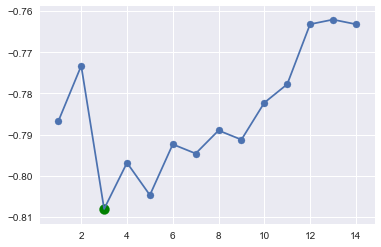

In [127]:
scores = [-x.mean_validation_score for x in gridsearch.grid_scores_]
plt.plot(depths, scores)
plt.scatter(depths, scores)
best_point = np.argmin(scores)
plt.scatter(depths[best_point], scores[best_point], c='g', s=100)

# Генерируем ответ

In [128]:
clf_final = DecisionTreeClassifier(max_depth=3)
clf_final.fit(Xtrain_prep, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [129]:
y_pred_proba = clf_final.predict_proba(Xtest_prep)
y_pred = clf_final.predict(Xtest_prep)

In [130]:
len( y_pred_proba)

418

In [131]:
len(test.PassengerId)

418

In [132]:
predicted_test_norm = []
for p in y_pred_proba:
    if p[1] > 0.6:
        predicted_test_norm.append(1)
    else:
        predicted_test_norm.append(0)
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted_test_norm):
        out.write('%s,%s\n' % (passenger, y))

## Рисуем дерево

In [133]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

http://www.webgraphviz.com

In [134]:
pd.Series(y).value_counts().sort_index()

0    1
dtype: int64

In [135]:
get_tree_dot_view(clf_final, list(Xtrain_prep.columns), list(["Die","Survived"]))

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="is_mail <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Die", fillcolor="#e5813960"] ;
1 [label="class3 <= 0.5\ngini = 0.3828\nsamples = 314\nvalue = [81, 233]\nclass = Survived", fillcolor="#399de5a6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="ticket_type_len <= 8.5\ngini = 0.1003\nsamples = 170\nvalue = [9, 161]\nclass = Survived", fillcolor="#399de5f1"] ;
1 -> 2 ;
3 [label="gini = 0.0902\nsamples = 169\nvalue = [8, 161]\nclass = Survived", fillcolor="#399de5f2"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Die", fillcolor="#e58139ff"] ;
2 -> 4 ;
5 [label="fare_fill <= 23.35\ngini = 0.5\nsamples = 144\nvalue = [72, 72]\nclass = Die", fillcolor="#e5813900"] ;
1 -> 5 ;
6 [label="gini = 0.4839\nsamples = 117\nvalue = [48, 69]\nclass = Survived", fillcolor="#399de54e"] ;
5 -> 6 ;
7 [label="gini = 0.1975\nsamples = 27\nvalue = [24, 3]\nclass 

In [136]:
Xtrain_prep.to_pickle('xtrain.pkl')
Xtest_prep.to_pickle('xtest.pkl')

In [43]:
from sklearn.externals import joblib
joblib.dump(clf, 'clf_decisiontree_maxdepth5.pkl')

['clf_decisiontree_maxdepth5.pkl']